#Image captioing model
This model uses seq2seq architecure with teacher forcing to caption images from MS COCO dataset.

Example image from model after training:

![](https://drive.google.com/uc?id=1xdcSs3naEnZc5gzhwQTGPCRx2W11qli0)

Note that attention can be added upon this architecure, but it takes more time to train.

### Importing relevant libraries

In [8]:
import sys
print(sys.executable)

c:\git\auto-public-report\.venv\Scripts\python.exe


In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from caption_templates import generate_caption_with_tokens, CATEGORIES

keras = tf.keras    

##Setting config parameters

In [10]:
max_cap_len = 10  # Determines max length of captioning sentences
img_dimension = 224 # Determines the height and width of images
num_words = 1000 # Determines vocab size to tokenize and train on
encoding_size = 256 # Determines dimension of the encodings of images
LSTM_size = 256
batch_size = 16
n_epochs = 50
Buffer_size = 100
validation_and_test_split = 0.3
test_to_val_split = 0.5
num_examples = None # Determines number of overall read samples. If set to none all samples will be read as long as they don't exceed max_cap_len

##Data Preprocessing


###Reading the data

In [11]:
# 데이터셋 경로 설정
annotation_file = './coco/annotations.json'
image_folder = './coco/images/'
PATH = image_folder

# JSON 파일 읽기
with open(annotation_file, 'r', encoding='utf-8') as f:
    annotations = json.load(f)

# 이미지 ID와 파일명 매핑 생성
image_id_to_filename = {}
for img in annotations['images']:
    image_id_to_filename[img['id']] = img['file_name']

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

# annotations 섹션이 있고 caption 필드가 있는지 확인
has_annotations = 'annotations' in annotations and len(annotations.get('annotations', [])) > 0
has_caption = has_annotations and 'caption' in annotations['annotations'][0]

if has_caption:
    # Case 1: caption 필드가 있는 경우
    for annot in annotations['annotations']:
        caption = annot['caption']
        
        # Removing the word 'a' from captions
        caption = caption.replace(" a ", " ")
        caption = caption.replace("A ", "")
        # Removing the word 'an' from captions
        caption = caption.replace("An ", "")
        caption = caption.replace(" an ", " ")
        # Removing the word 'the' from captions
        caption = caption.replace(" the ", " ")
        caption = caption.replace("The ", "")
        
        # Load only captions that don't exceed maximum length
        if len(caption.split(" ")) > max_cap_len:
            continue
        else:
            caption = '<sos> ' + caption + ' <eos>'
            image_id = annot['image_id']
            
            image_filename = image_id_to_filename[image_id]
            full_image_path = PATH + image_filename
            
            all_img_name_vector.append(full_image_path)
            all_captions.append(caption)
else:
    # Case 2: caption이 없는 경우 - category로 자동 생성
    print("No caption field found. Generating captions from category...")
    
    for img in annotations['images']:
        category = img.get('category', 'good')
        
        # caption_templates 사용하여 캡션 생성
        caption = generate_caption_with_tokens(category, preprocess=True, random_choice=True)
        
        full_image_path = PATH + img['file_name']
        
        all_img_name_vector.append(full_image_path)
        all_captions.append(caption)

# Shuffle captions and image_names together
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=42)

# num_examples 적용
if num_examples is not None:
    train_captions = train_captions[:num_examples]
    img_name_vector = img_name_vector[:num_examples]

# Train/Val/Test split
caption_train, captions_test, img_name_vector_train, img_name_vector_test = train_test_split(
    train_captions,
    img_name_vector,
    test_size=validation_and_test_split,
    random_state=42
)

caption_val, caption_test, img_name_vector_val, img_name_vector_test = train_test_split(
    captions_test,
    img_name_vector_test,
    test_size=test_to_val_split,
    random_state=42
)

num_samples = len(img_name_vector)
assert len(train_captions) == len(img_name_vector)
print("Loaded %d samples" %(num_samples))
print("Loaded %d train samples" %(len(caption_train)))
print("Loaded %d valid samples" %(len(caption_val)))
print("Loaded %d test samples" %(len(caption_test)))

Loaded 705 samples
Loaded 493 train samples
Loaded 106 valid samples
Loaded 106 test samples


###Tokenizing and padding captions

In [21]:
tok = keras.preprocessing.text.Tokenizer(num_words = num_words
                                         ,filters ="!?,'()_-+=&*$#@.",oov_token="<unk>")
tok.fit_on_texts(caption_train)
captions_train = tok.texts_to_sequences(caption_train)
if num_words == None:
  words = len(tok.word_index)
else:
  words = num_words
captions_train = keras.preprocessing.sequence.pad_sequences(captions_train, padding='post',maxlen=max_cap_len + 2)
print("Examlpe:", captions_train[np.random.randint(low=0, high= len(captions_train) - 1,size=1)[0]])
print("Found %d unique words" %(words))

Examlpe: [ 2  4  7 12 10  3  0  0  0  0  0  0]
Found 1000 unique words


In [13]:
captions_valid = tok.texts_to_sequences(caption_val)
captions_valid = keras.preprocessing.sequence.pad_sequences(captions_valid, padding='post',maxlen=max_cap_len + 2)

###Defining preprocessing functions of dataset
tf.data api is used for making efficient input pipelines as the data is huge for ram.

In [22]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (img_dimension, img_dimension))
  return img

In [23]:
def preprocess_func(path_index, caption):
  #Reading the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(img_name_vector_train,indices=path_index)
  img = load_img(path)#/255.0
  #Preprocessing text
  teacher_caption = caption[:-1]
  tar_caption = caption[1:]
  
  h_and_c_init = tf.zeros((LSTM_size))
   
  return (img,h_and_c_init,teacher_caption), tar_caption 

In [24]:
def preprocess_func_val(path_index, caption):
  #Reading the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(img_name_vector_val,indices=path_index)
  img = load_img(path)#/255.0
  #Preprocessing text
  teacher_caption = caption[:-1]
  tar_caption = caption[1:]

  h_and_c_init = tf.zeros((LSTM_size))
  
  return (img,h_and_c_init,teacher_caption), tar_caption 

In [25]:
#Creating an array to index each img path for reading 
path_index_vec_train = np.array(list(range(0,len(img_name_vector_train)))).reshape(-1,1)
path_index_vec_val = np.array(list(range(0,len(img_name_vector_val)))).reshape(-1,1)

dataset1_train = tf.data.Dataset.from_tensor_slices(path_index_vec_train)
dataset2_train = tf.data.Dataset.from_tensor_slices(captions_train)
dataset = tf.data.Dataset.zip((dataset1_train,dataset2_train))
dataset = dataset.map(preprocess_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset1_val = tf.data.Dataset.from_tensor_slices(path_index_vec_val)
dataset2_val = tf.data.Dataset.from_tensor_slices(captions_valid)
dataset_val = tf.data.Dataset.zip((dataset1_val,dataset2_val))
dataset_val = dataset_val.map(preprocess_func_val, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [26]:
dataset = dataset.shuffle(Buffer_size).batch(batch_size,drop_remainder=True).prefetch(1)
dataset_val = dataset_val.shuffle(Buffer_size).batch(batch_size,drop_remainder=True).prefetch(1)  # 256 → batch_size

##Building the model

###Downloading Inception and freezing it.

In [27]:
from keras.applications.inception_v3 import preprocess_input


incep = keras.applications.inception_v3.InceptionV3(input_shape=(img_dimension,img_dimension,3),
                                                    include_top=False)
incep.trainable=False
incep.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 109, 109,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 109, 109,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 54, 54,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 54, 54,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 52, 52,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
from keras.applications.inception_v3 import preprocess_input

incep = keras.applications.inception_v3.InceptionV3(input_shape=(img_dimension,img_dimension,3),
                                                    include_top=False)
incep.trainable=False

# InceptionV3의 출력 shape 확인
print("InceptionV3 output shape:", incep.output_shape)

encoder = keras.models.Sequential([
    keras.layers.Lambda(preprocess_input,input_shape=(img_dimension,img_dimension,3),name="preprocessing_layer"),
    incep,
    keras.layers.GlobalAveragePooling2D(name="pooling_layer"),  # 추가
    keras.layers.Dense(encoding_size,activation='relu',name="encoding_layer"),
    keras.layers.RepeatVector(64, name="repeat_layer")  # Reshape 대신 사용
],name="Encoder")

encoder.summary()

InceptionV3 output shape: (None, 5, 5, 2048)


Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocessing_layer (Lambda)    │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoding_layer (Dense)          │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_layer (RepeatVector)     │ (None, 64, 256)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,327,328 (85.17 MB)

 Trainable params: 524,544 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

###Completing the model

####Building attention mechanism
This is Bahdanau attention, A soft attention mechanism that works through linear combination of previous state and the whole image.

In [34]:
W1 = keras.layers.Dense(512,name="W1")
W2 = keras.layers.Dense(512,name="W2")
V = keras.layers.Dense(1,name="V")
repeater = keras.layers.RepeatVector(8*8)
doter = keras.layers.Dot(axes=1)
concatenator = keras.layers.Concatenate()

def attention_step(enc,h_prev):
  h = repeater(h_prev)
  score = keras.activations.tanh(W1(enc) + W2(h))  # tf.nn.tanh → keras.activations.tanh
  
  alphas = keras.activations.softmax(V(score), axis=1)  # tf.nn.softmax → keras.activations.softmax
  
  context = doter([alphas,enc])
  return context

####Building the deoder

This decoder goes one time-step at a time.

So, a custom training function is required.

In [35]:
encodings = keras.layers.Input(shape=(8*8,encoding_size))

init_h = keras.layers.Input(shape=(LSTM_size,))  # 쉼표 추가
init_c = keras.layers.Input(shape=(LSTM_size,))  # 쉼표 추가

teacher_forcing = keras.layers.Input(shape=(1,))  # 쉼표 추가

embedding_layer = keras.layers.Embedding(words+1,256,)

context_prev_tar_concat_layer = keras.layers.Concatenate()
decoder_lstm_layer = keras.layers.LSTM(LSTM_size,return_state=True,dropout=0.2)
decoder_dense_layer = keras.layers.Dense(words+1,activation='softmax')

h = init_h

c = init_c

context = attention_step(encodings,h)

embedds = embedding_layer(teacher_forcing)

decoder_lstm_input = context_prev_tar_concat_layer([context,embedds])
  
h , _ , c = decoder_lstm_layer(decoder_lstm_input,initial_state=[h,c])
  
out = decoder_dense_layer(h)

decoder = keras.models.Model([encodings,init_h,init_c,teacher_forcing],[out,h,c])
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 64, 256)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 64, 256)   │          0 │ input_layer_20[0… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ W1 (Dense)          │ (None, 64, 512)   │    131,584 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ W2 (Dense)          │ (None, 64, 512)   │    131,584 │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 64, 512)   │          0 │ W1[0][0],         │
│                     │                   │            │ W2[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tanh (Tanh)         │ (None, 64, 512)   │          0 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V (Dense)           │ (None, 64, 1)     │        513 │ tanh[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 64, 1)     │          0 │ V[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_22      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 1, 256)    │          0 │ softmax[0][0],    │
│                     │                   │            │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 256)    │    256,256 │ input_layer_22[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 1, 512)    │          0 │ dot_1[0][0],      │
│ (Concatenate)       │                   │            │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_21      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 256),     │    787,456 │ concatenate_11[0… │
│                     │ (None, 256),      │            │ input_layer_20[0… │
│                     │ (None, 256)]      │            │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1001)      │    257,257 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,564,650 (5.97 MB)

 Trainable params: 1,564,650 (5.97 MB)

 Non-trainable params: 0 (0.00 B)

    ##Defining custom loss function
    This loss function masks the padded steps and also one-hot enodes the targets

In [36]:
def sparse_it_up(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))

  real = tf.cast(real,tf.int64)
  real = tf.one_hot(real,words+1,axis=-1)

  loss_ = tf.losses.categorical_crossentropy(real, pred)

  mask = tf.cast(mask, dtype=tf.float32)

  loss_ *= mask

  return tf.reduce_mean(loss_)


##Defining the custom train loop

This custorm training loop was inspired from the google documentation linked above aswell.

In [37]:
optimizer = keras.optimizers.Adam()

@tf.function
def train_step(img,init_state,teacher,target):
  with tf.GradientTape() as tape:

    encodings = encoder(img)
    h = init_state
    c = init_state
    loss = 0
    for i in range(max_cap_len+1):
      dec_inp = teacher[:,i:i+1]
      o, h , c = decoder([encodings,h,c,dec_inp])

      loss += sparse_it_up(target[:,i],o) 

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss


In [38]:
'''This function is for forward passing features for calculating losses with no backprop'''
@tf.function
def valid_step(img,init_state,teacher,target):
  # GradientTape 제거 (backprop 필요 없음)
  encodings = encoder(img)
  h = init_state
  c = init_state
  loss = 0
  for i in range(max_cap_len+1):
    dec_inp = teacher[:,i:i+1]
    o, h , c = decoder([encodings,h,c,dec_inp])

    loss += sparse_it_up(target[:,i],o) 

  return loss

##Training the model
One training epoch takes about 35 minutes on google colab with gpu.

So, get busy doing something else for a while! or just go for a smaller num_examples set from the configuration cell.

In [39]:
import time
import numpy as np

EPOCHS = n_epochs  # 설정한 n_epochs 사용

prev_loss = np.inf

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, ((img, s, teacher) ,target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img, s, teacher ,target)
        total_loss += t_loss

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    
    val_loss=0

    for (i, ((img, s, teacher) ,target)) in enumerate(dataset_val):
      val_loss += valid_step(img, s, teacher ,target)
    
    val_loss = val_loss.numpy()/((i+1)*(max_cap_len+1))
    
    epoch_time = time.time() - start  # 추가
    print(f'Epoch {epoch + 1} completed in {epoch_time:.2f}s')  # 추가
    print(f"Validation Loss: {val_loss:.4f}")  # 개선
    
    # This code makes sure we only save the best val_loss score weights
    if val_loss < prev_loss:
      print("Model improved. Saving...")  # 오타 수정: imporved → improved

      encoder.save("encoder.hdf5")
      decoder.save("decoder.hdf5")
    
    else:
      print("Model didn't improve.")  # 오타 수정: imporve → improve

    prev_loss = val_loss

print("\nTraining completed!")

Epoch 1 Batch 0 Loss 3.3232


Epoch 1 completed in 24.79s
Validation Loss: 1.1853
Model improved. Saving...


Epoch 2 Batch 0 Loss 1.1709


Epoch 2 completed in 19.34s
Validation Loss: 0.9967
Model improved. Saving...


Epoch 3 Batch 0 Loss 1.0097


Epoch 3 completed in 20.59s
Validation Loss: 0.8399
Model improved. Saving...


Epoch 4 Batch 0 Loss 0.8671


Epoch 4 completed in 9.52s
Validation Loss: 0.6956
Model improved. Saving...


Epoch 5 Batch 0 Loss 0.6061


Epoch 5 completed in 10.01s
Validation Loss: 0.5563
Model improved. Saving...


Epoch 6 Batch 0 Loss 0.5661


Epoch 6 completed in 10.16s
Validation Loss: 0.4529
Model improved. Saving...


Epoch 7 Batch 0 Loss 0.4177


Epoch 7 completed in 9.76s
Validation Loss: 0.3599
Model improved. Saving...


Epoch 8 Batch 0 Loss 0.3783


Epoch 8 completed in 10.18s
Validation Loss: 0.3098
Model improved. Saving...


Epoch 9 Batch 0 Loss 0.2591


Epoch 9 completed in 9.80s
Validation Loss: 0.2640
Model improved. Saving...


Epoch 10 Batch 0 Loss 0.2574


Epoch 10 completed in 9.87s
Validation Loss: 0.2361
Model improved. Saving...


Epoch 11 Batch 0 Loss 0.2164


Epoch 11 completed in 9.83s
Validation Loss: 0.2158
Model improved. Saving...


Epoch 12 Batch 0 Loss 0.1927


Epoch 12 completed in 9.83s
Validation Loss: 0.1932
Model improved. Saving...


Epoch 13 Batch 0 Loss 0.1681


Epoch 13 completed in 9.97s
Validation Loss: 0.1760
Model improved. Saving...


Epoch 14 Batch 0 Loss 0.1589


Epoch 14 completed in 9.98s
Validation Loss: 0.1606
Model improved. Saving...


Epoch 15 Batch 0 Loss 0.1375


Epoch 15 completed in 10.17s
Validation Loss: 0.1604
Model improved. Saving...


Epoch 16 Batch 0 Loss 0.1271


Epoch 16 completed in 11.67s
Validation Loss: 0.1492
Model improved. Saving...


Epoch 17 Batch 0 Loss 0.1173


Epoch 17 completed in 9.71s
Validation Loss: 0.1429
Model improved. Saving...


Epoch 18 Batch 0 Loss 0.1195


Epoch 18 completed in 10.19s
Validation Loss: 0.1410
Model improved. Saving...


Epoch 19 Batch 0 Loss 0.1139
Epoch 19 completed in 10.15s
Validation Loss: 0.1443
Model didn't improve.
Epoch 20 Batch 0 Loss 0.1132
Epoch 20 completed in 10.18s
Validation Loss: 0.1607
Model didn't improve.
Epoch 21 Batch 0 Loss 0.1088


Epoch 21 completed in 10.13s
Validation Loss: 0.1392
Model improved. Saving...


Epoch 22 Batch 0 Loss 0.1101


Epoch 22 completed in 10.06s
Validation Loss: 0.1377
Model improved. Saving...


Epoch 23 Batch 0 Loss 0.1080
Epoch 23 completed in 10.08s
Validation Loss: 0.2077
Model didn't improve.
Epoch 24 Batch 0 Loss 0.1607


Epoch 24 completed in 10.14s
Validation Loss: 0.1482
Model improved. Saving...


Epoch 25 Batch 0 Loss 0.1028


Epoch 25 completed in 10.16s
Validation Loss: 0.1482
Model improved. Saving...


Epoch 26 Batch 0 Loss 0.1163
Epoch 26 completed in 10.27s
Validation Loss: 0.1542
Model didn't improve.
Epoch 27 Batch 0 Loss 0.0929
Epoch 27 completed in 10.99s
Validation Loss: 0.1644
Model didn't improve.
Epoch 28 Batch 0 Loss 0.1036


Epoch 28 completed in 10.76s
Validation Loss: 0.1516
Model improved. Saving...


Epoch 29 Batch 0 Loss 0.0979


Epoch 29 completed in 10.49s
Validation Loss: 0.1488
Model improved. Saving...


Epoch 30 Batch 0 Loss 0.0903


Epoch 30 completed in 11.26s
Validation Loss: 0.1472
Model improved. Saving...


Epoch 31 Batch 0 Loss 0.0979
Epoch 31 completed in 10.64s
Validation Loss: 0.1635
Model didn't improve.
Epoch 32 Batch 0 Loss 0.0854
Epoch 32 completed in 11.24s
Validation Loss: 0.1648
Model didn't improve.
Epoch 33 Batch 0 Loss 0.0821
Epoch 33 completed in 10.62s
Validation Loss: 0.1686
Model didn't improve.
Epoch 34 Batch 0 Loss 0.1043
Epoch 34 completed in 10.51s
Validation Loss: 0.1757
Model didn't improve.
Epoch 35 Batch 0 Loss 0.1140


Epoch 35 completed in 10.84s
Validation Loss: 0.1702
Model improved. Saving...


Epoch 36 Batch 0 Loss 0.1108


Epoch 36 completed in 12.31s
Validation Loss: 0.1683
Model improved. Saving...


Epoch 37 Batch 0 Loss 0.0903
Epoch 37 completed in 16.83s
Validation Loss: 0.1741
Model didn't improve.
Epoch 38 Batch 0 Loss 0.1065


Epoch 38 completed in 9.44s
Validation Loss: 0.1698
Model improved. Saving...


Epoch 39 Batch 0 Loss 0.0932
Epoch 39 completed in 11.30s
Validation Loss: 0.1892
Model didn't improve.
Epoch 40 Batch 0 Loss 0.0868


Epoch 40 completed in 10.70s
Validation Loss: 0.1818
Model improved. Saving...


Epoch 41 Batch 0 Loss 0.0912
Epoch 41 completed in 21.44s
Validation Loss: 0.1873
Model didn't improve.
Epoch 42 Batch 0 Loss 0.1015
Epoch 42 completed in 22.81s
Validation Loss: 0.1982
Model didn't improve.
Epoch 43 Batch 0 Loss 0.1091


Epoch 43 completed in 22.32s
Validation Loss: 0.1880
Model improved. Saving...


Epoch 44 Batch 0 Loss 0.0925
Epoch 44 completed in 21.88s
Validation Loss: 0.2092
Model didn't improve.
Epoch 45 Batch 0 Loss 0.0936


Epoch 45 completed in 21.88s
Validation Loss: 0.2035
Model improved. Saving...


Epoch 46 Batch 0 Loss 0.0932
Epoch 46 completed in 21.91s
Validation Loss: 0.2045
Model didn't improve.
Epoch 47 Batch 0 Loss 0.0872
Epoch 47 completed in 9.30s
Validation Loss: 0.2062
Model didn't improve.
Epoch 48 Batch 0 Loss 0.0825
Epoch 48 completed in 9.09s
Validation Loss: 0.2207
Model didn't improve.
Epoch 49 Batch 0 Loss 0.1072


Epoch 49 completed in 9.01s
Validation Loss: 0.2160
Model improved. Saving...


Epoch 50 Batch 0 Loss 0.0854
Epoch 50 completed in 8.99s
Validation Loss: 0.2259
Model didn't improve.

Training completed!


In [ ]:
# Loading the best validation accuracy score weights
encoder.load_weights("encoder.hdf5")
decoder.load_weights("decoder.hdf5")

##Prediction function
This function takes its input as path of an image and captions it

In [41]:
def caption_image(path):
  image = load_img(path)

  encodings = encoder.predict(tf.reshape(image,(1,img_dimension,img_dimension,3)), verbose=0)  # verbose=0 추가

  texts = ["<sos>"]
  h = np.zeros((1,LSTM_size))
  c = np.zeros((1,LSTM_size))
  
  for _ in range(max_cap_len + 1):
    dec_inp = np.array(tok.word_index.get(texts[-1], 1)).reshape(1,-1)  # default=1 추가 (unknown token)
    
    props, h, c = decoder.predict([encodings, h, c, dec_inp], verbose=0)  # verbose=0 추가
    props = props[0]
    idx = np.argmax(props)
    
    word = tok.index_word.get(idx, '<unk>')  # default 추가
    texts.append(word)
    
    if word == '<eos>':
      break
  
  if texts[-1] != '<eos>':
    texts.append('<eos>')
  
  caption_text = ' '.join(texts)
  print(f"Caption: {caption_text}")
  
  plt.figure(figsize=(8, 6))  # 크기 추가
  plt.imshow(image/255.0)
  plt.title(caption_text, fontsize=12)  # 제목 추가
  plt.axis("off")
  plt.show()  # 명시적 표시
  
  return caption_text  # 결과 반환

###Some random predictions for fun.
Apparently the model performs well, but it sometimes deviates from its desired destination when it starts describing some details.

I have split some of the predections into the good, the meh and the ugly.

Keep in mind that most of the predections i tried on my own fell into 'the good' region.

####The good

Caption: <sos> road surface is cracked <eos>


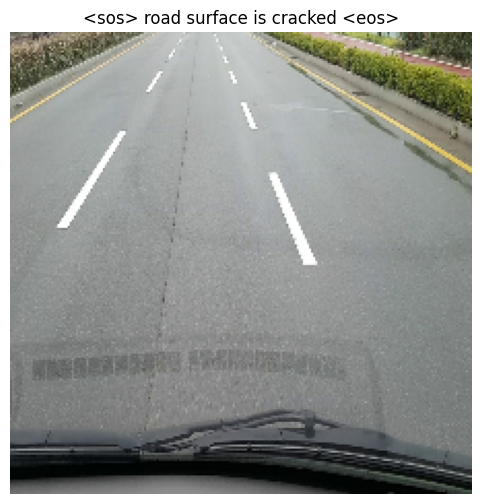

'<sos> road surface is cracked <eos>'

In [42]:
caption_image('./coco/images/cracked_0001.jpg')

Caption: <sos> this pavement is well maintained <eos>


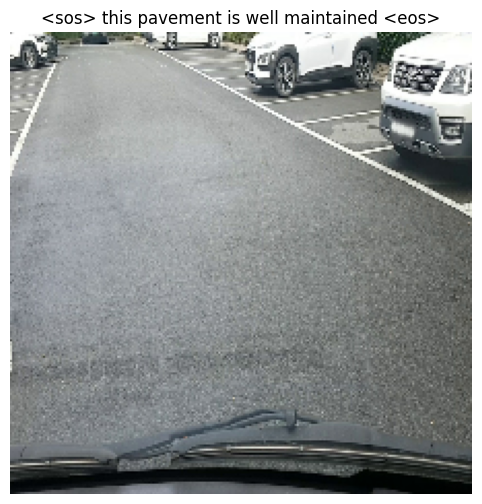

'<sos> this pavement is well maintained <eos>'

In [43]:
caption_image('./coco/images/good_0015.jpg')

In [1]:
caption_image('./coco/images/potholed_0023.jpg')

NameError: name 'caption_image' is not defined

In [ ]:
caption_image(img_name_vector_test[600])

In [ ]:
caption_image(img_name_vector_test[2048])

####The meh..

In [ ]:
caption_image(img_name_vector_test[12])

In [ ]:
caption_image(img_name_vector_test[906])

In [ ]:
caption_image(img_name_vector_test[929])

In [ ]:
caption_image(img_name_vector_test[873])

####The ugly

In [ ]:
caption_image(img_name_vector_test[22])

In [ ]:
caption_image(img_name_vector_test[400])

In [ ]:
caption_image(img_name_vector_test[9000])

##Saving the dictionary

In [48]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)

## ftlite 추출

In [49]:
import tensorflow as tf
import numpy as np
import json

print("="*60)
print("Starting TFLite Conversion Process")
print("="*60)

# ============================================
# Step 1: Encoder를 TFLite로 변환
# ============================================
print("\n[1/4] Converting Encoder to TFLite...")

try:
    converter_encoder = tf.lite.TFLiteConverter.from_keras_model(encoder)
    converter_encoder.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_encoder = converter_encoder.convert()
    
    with open('encoder.tflite', 'wb') as f:
        f.write(tflite_encoder)
    print("✓ SUCCESS: encoder.tflite created")
    print(f"  File size: {len(tflite_encoder) / 1024:.2f} KB")
except Exception as e:
    print(f"❌ FAILED: {e}")
    print("Trying without optimization...")
    converter_encoder = tf.lite.TFLiteConverter.from_keras_model(encoder)
    tflite_encoder = converter_encoder.convert()
    with open('encoder.tflite', 'wb') as f:
        f.write(tflite_encoder)
    print("✓ encoder.tflite created (unoptimized)")

# ============================================
# Step 2: Decoder - 직접 변환 시도
# ============================================
print("\n[2/4] Converting Decoder to TFLite...")

try:
    # 방법 1: 기존 decoder 직접 변환 시도
    print("Attempting direct conversion...")
    converter_decoder = tf.lite.TFLiteConverter.from_keras_model(decoder)
    
    # LSTM을 위한 설정
    converter_decoder.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,  # TFLite ops
        tf.lite.OpsSet.SELECT_TF_OPS      # 일부 TF ops 허용
    ]
    converter_decoder._experimental_lower_tensor_list_ops = False
    
    tflite_decoder = converter_decoder.convert()
    
    with open('decoder.tflite', 'wb') as f:
        f.write(tflite_decoder)
    print("✓ SUCCESS: decoder.tflite created")
    print(f"  File size: {len(tflite_decoder) / 1024:.2f} KB")
    
except Exception as e:
    print(f"⚠ Direct conversion failed: {e}")
    print("\nThis is EXPECTED due to custom attention mechanism.")
    print("Decoder will need special handling in Android.")
    print("Consider using:")
    print("  1. TensorFlow Lite with SELECT_TF_OPS")
    print("  2. Or implement attention in Kotlin/Java")

# ============================================
# Step 3: Tokenizer 저장
# ============================================
print("\n[3/4] Saving Tokenizer...")

tokenizer_config = {
    'word_index': tok.word_index,
    'index_word': {int(k): v for k, v in tok.index_word.items()},
    'num_words': words,
    'vocab_size': len(tok.word_index)
}

with open('tokenizer.json', 'w', encoding='utf-8') as f:
    json.dump(tokenizer_config, f, ensure_ascii=False, indent=2)

print("✓ SUCCESS: tokenizer.json created")
print(f"  Vocabulary size: {len(tok.word_index)} words")

# 샘플 출력
print("\n  Sample word_index:")
sample_words = list(tok.word_index.items())[:5]
for word, idx in sample_words:
    print(f"    '{word}': {idx}")

# ============================================
# Step 4: 모델 설정 저장
# ============================================
print("\n[4/4] Saving Model Configuration...")

model_config = {
    'img_dimension': int(img_dimension),
    'max_cap_len': int(max_cap_len),
    'encoding_size': int(encoding_size),
    'LSTM_size': int(LSTM_size),
    'num_words': int(words),
    'batch_size': int(batch_size),
    'categories': ['cracked', 'pothole', 'good']
}

with open('model_config.json', 'w', encoding='utf-8') as f:
    json.dump(model_config, f, indent=2)

print("✓ SUCCESS: model_config.json created")
print("\n  Configuration:")
for key, value in model_config.items():
    print(f"    {key}: {value}")

# ============================================
# Step 5: 검증 테스트
# ============================================
print("\n" + "="*60)
print("Verification Test")
print("="*60)

# Encoder 테스트
print("\nTesting encoder.tflite...")
try:
    interpreter_encoder = tf.lite.Interpreter(model_path="encoder.tflite")
    interpreter_encoder.allocate_tensors()
    
    input_details = interpreter_encoder.get_input_details()
    output_details = interpreter_encoder.get_output_details()
    
    print("✓ Encoder loads successfully")
    print(f"  Input shape: {input_details[0]['shape']}")
    print(f"  Output shape: {output_details[0]['shape']}")
    
    # 테스트 실행
    test_input = np.random.random(input_details[0]['shape']).astype(np.float32)
    interpreter_encoder.set_tensor(input_details[0]['index'], test_input)
    interpreter_encoder.invoke()
    test_output = interpreter_encoder.get_tensor(output_details[0]['index'])
    print(f"  Test inference successful! Output shape: {test_output.shape}")
    
except Exception as e:
    print(f"❌ Encoder test failed: {e}")

# Decoder 테스트 (있는 경우)
print("\nTesting decoder.tflite...")
try:
    interpreter_decoder = tf.lite.Interpreter(model_path="decoder.tflite")
    interpreter_decoder.allocate_tensors()
    
    input_details = interpreter_decoder.get_input_details()
    output_details = interpreter_decoder.get_output_details()
    
    print("✓ Decoder loads successfully")
    print(f"  Number of inputs: {len(input_details)}")
    print(f"  Number of outputs: {len(output_details)}")
    
    for i, detail in enumerate(input_details):
        print(f"  Input {i}: shape={detail['shape']}, dtype={detail['dtype']}")
    
except FileNotFoundError:
    print("⚠ decoder.tflite not found (expected if conversion failed)")
except Exception as e:
    print(f"❌ Decoder test failed: {e}")

# ============================================
# Summary
# ============================================
print("\n" + "="*60)
print("Conversion Summary")
print("="*60)

import os
files_created = []
for filename in ['encoder.tflite', 'decoder.tflite', 'tokenizer.json', 'model_config.json']:
    if os.path.exists(filename):
        size = os.path.getsize(filename)
        files_created.append((filename, size))
        print(f"✓ {filename:<25} ({size/1024:.2f} KB)")
    else:
        print(f"✗ {filename:<25} (NOT CREATED)")

print("\n" + "="*60)
print("Next Steps for Android Integration:")
print("="*60)
print("1. Copy all created files to Android assets folder")
print("2. Add TensorFlow Lite dependency to build.gradle:")
print("   implementation 'org.tensorflow:tensorflow-lite:2.14.0'")
print("3. If decoder.tflite failed, you have two options:")
print("   a. Use TensorFlow Lite with SELECT_TF_OPS support")
print("   b. Implement a simpler decoder or use classification only")
print("\nFor code examples, ask for Android integration help!")
print("="*60)

Starting TFLite Conversion Process

[1/4] Converting Encoder to TFLite...
INFO:tensorflow:Assets written to: C:\Users\eg4ra\AppData\Local\Temp\tmppfmmcngp\assets


INFO:tensorflow:Assets written to: C:\Users\eg4ra\AppData\Local\Temp\tmppfmmcngp\assets


Saved artifact at 'C:\Users\eg4ra\AppData\Local\Temp\tmppfmmcngp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_939')
Output Type:
  TensorSpec(shape=(None, 64, 256), dtype=tf.float32, name=None)
Captures:
  2401406597632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2401606636416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2401606637648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2401606634480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2401606642928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2401606643808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2401606644688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2401606642048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2401606643104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2401406979584: TensorSpec(shape=(), dtype=tf.resource, name=Non

INFO:tensorflow:Assets written to: C:\Users\eg4ra\AppData\Local\Temp\tmpxll1nuhz\assets


Saved artifact at 'C:\Users\eg4ra\AppData\Local\Temp\tmpxll1nuhz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 64, 256), dtype=tf.float32, name='keras_tensor_972'), TensorSpec(shape=(None, 256), dtype=tf.float32, name='keras_tensor_973'), TensorSpec(shape=(None, 256), dtype=tf.float32, name='keras_tensor_974'), TensorSpec(shape=(None, 1), dtype=tf.float32, name='keras_tensor_975')]
Output Type:
  List[TensorSpec(shape=(None, 1001), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256), dtype=tf.float32, name=None)]
Captures:
  2401638149360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2401682677024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2401682670864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2401682676144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2401637883872: TensorSpec(shape=(), dtype=tf.resource, nam

c:\git\auto-public-report\.venv\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
